# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.autograd import gradcheck
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_smap_loss
from Preprocessing import random_spatial_sequence, collate_fn, collate_insitu_validation

C:\Users\jianer\anaconda3\envs\datamining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 71, 
    'valid_batch_size': 78,
    'test_batch_size': 197,
    'penalty_constant': {
        'sd_lambda': 1,
        'sm_lambda': 60,
        'eds_lambda': 10,
        'sd_threshold': 0,
        'sm_threshold': 15,
        'eds_threshold': 0
    },
    'learning_rate': 5e-4,
    'step_size': 10,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 50,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SE',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SE\\OUTPUT\\MODELS\\CNN_FROM_UPSCALING'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
# 创建数据集
dataset = SMAPDataset(config['root'])

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70
***************************Load data path******************************
valid day sequence: ['2015104', '2015106', '2015114', '2015115', '2015117', '2015128', '2015130', '2015131', '2015136', '2015138', '2015141', '2015149', '2015154', '2015157', '2015160', '2015162', '2015163', '2015165', '2015171', '2015176', '2015186', '2015187', '2015189', '2015194', '2015195', '2015197', '2015200', '2015202', '2015203', '2015205', '2015208', '2015211', '2015213', '2015216', '2015221', '2015226', '2015229', '2015232', '2015234', '2015235', '2015237', '2015242', '2015243', '2015258', '2015259', '2015261', '2015267', '2015272', '2015275', '2015277', '2015280', '2015282', '2015283', '2015285', '2015288', '2015290', '2015291', '2015296', '2015325', '2015330', '2015333']
_______________________________2015104_______________________________
_____________________________smap cell: 1_____________________________
D

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015171\45.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015171\45.npy
_____________________________smap cell: 49_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015171\49.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\49.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015171\49.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015171\49.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015171\49.npy
_____________________________smap cell: 50_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015171\50.npy
D:\1GRADUATED\paper\downsc

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015226\54.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015226\54.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015226\54.npy
_____________________________smap cell: 55_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015226\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015226\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015226\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015226\55.npy
_____________________________smap cell: 56_____________________________
D:\1GRADUATED\paper\d

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015288\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015288\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015288\2.npy
_____________________________smap cell: 20_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015288\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015288\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015288\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015288\20.npy


In [6]:
# 计算训练集和测试集的长度
train_len = int(len(dataset) * (1-config['test_ratio']))
test_len = len(dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_fn)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 710
validing size 78
testing size 197


# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_smap_loss 
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        if epoch==35:
            config['sim_threshold'] = 1
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        sd_nonzero_loss_record = []
        sm_nonzero_loss_record = []
        eds_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               
            pred = model(x)
#             print(pred.requires_grad)
#             print(pred)
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sd_nonzero_loss, sm_nonzero_loss, eds_loss = criterion(pred, 
                                                                        data_pkg['label_data'], 
                                                                        'Training',
                                                                        config['penalty_constant'])
            loss = physical_loss + sd_nonzero_loss + sm_nonzero_loss + eds_loss
            loss.backward()                     
            optimizer.step()                   
            step += 1
            
            physical_loss_record.append(physical_loss.detach().item())
            sd_nonzero_loss_record.append(sd_nonzero_loss.detach().item())
            sm_nonzero_loss_record.append(sm_nonzero_loss.detach().item())
            eds_loss_record.append(eds_loss.item())
            loss_record.append(loss.detach().item())
         
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_sd_nonzero_loss = sum(sd_nonzero_loss_record)/len(sd_nonzero_loss_record)
        mean_train_sm_nonzero_loss = sum(sm_nonzero_loss_record)/len(sm_nonzero_loss_record)
        mean_train_eds_loss = sum(eds_loss_record)/len(eds_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() 
        loss_record = []
        physical_loss_record = []
        sd_nonzero_loss_record = []
        sm_nonzero_loss_record = []
        eds_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
#                 relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
                physical_loss, sd_nonzero_loss, sm_nonzero_loss, eds_loss = criterion(pred,
                                                                            data_pkg['label_data'],
                                                                            'Validing',
                                                                            config['penalty_constant'])
                loss = physical_loss + sd_nonzero_loss + sm_nonzero_loss + eds_loss
            
            physical_loss_record.append(physical_loss.item())
            sd_nonzero_loss_record.append(sd_nonzero_loss.item())
            sm_nonzero_loss_record.append(sm_nonzero_loss.item())
            eds_loss_record.append(eds_loss.item())
            loss_record.append(loss.item())

        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_valid_sd_nonzero_loss = sum(sd_nonzero_loss_record)/len(sd_nonzero_loss_record)
        mean_valid_sm_nonzero_loss = sum(sm_nonzero_loss_record)/len(sm_nonzero_loss_record)
        mean_valid_eds_loss = sum(eds_loss_record)/len(eds_loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || physical loss: {mean_train_physical_loss:.4f}')
        print(f'Train sd_nonzero_loss: {mean_train_sd_nonzero_loss:.4f} || sm_nonzero_loss: {mean_train_sm_nonzero_loss:.4f} || eds_loss: {mean_train_eds_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || physical loss: {mean_valid_physical_loss:.4f}')
        print(f'Valid sd_nonzero_loss: {mean_valid_sd_nonzero_loss:.4f} || sm_nonzero_loss: {mean_valid_sm_nonzero_loss:.4f} || eds_loss: {mean_valid_eds_loss:.4f}')
            
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'first'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            print(os.path.join(config['model_save_dir'], _name + '.ckpt'))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'last'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Start training!

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


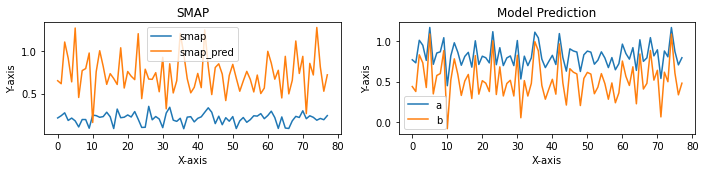

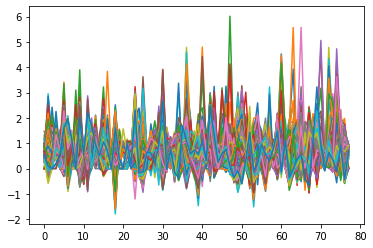

Epoch [1/5000] (LR: 0.0005):
Train loss: 40.8118 || physical loss: 0.9692
Train sd_nonzero_loss: 15.9411 || sm_nonzero_loss: 23.0409 || eds_loss: 0.8607
Valid loss: 32.8784 || physical loss: 0.3295
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 31.6875 || eds_loss: 0.8614
Saving model with loss 32.878...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


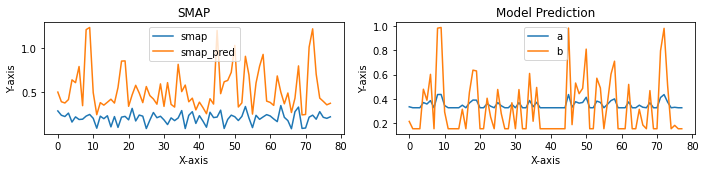

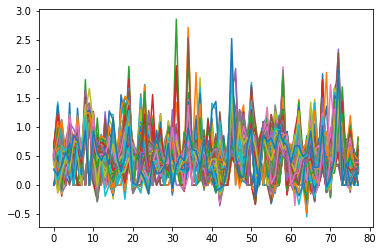

Epoch [2/5000] (LR: 0.0005):
Train loss: 16.2347 || physical loss: 0.8374
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 14.5484 || eds_loss: 0.8490
Valid loss: 18.1709 || physical loss: 0.1646
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 17.0369 || eds_loss: 0.9693
Saving model with loss 18.171...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


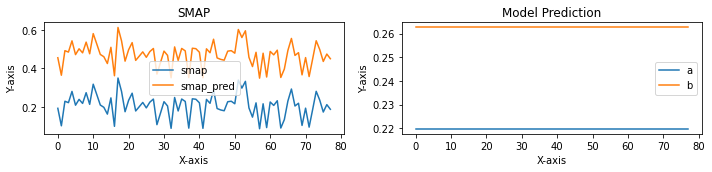

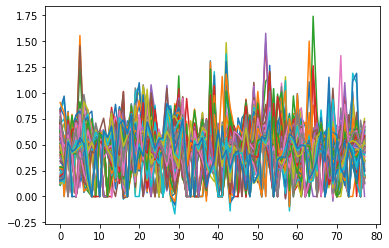

Epoch [3/5000] (LR: 0.0005):
Train loss: 2.7115 || physical loss: 0.1380
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 1.5850 || eds_loss: 0.9884
Valid loss: 1.0689 || physical loss: 0.0689
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.069...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


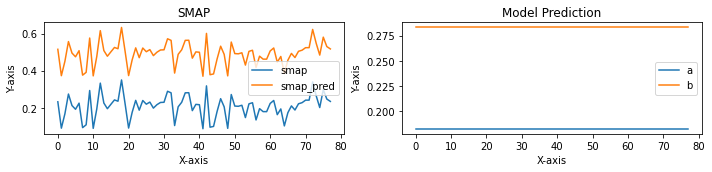

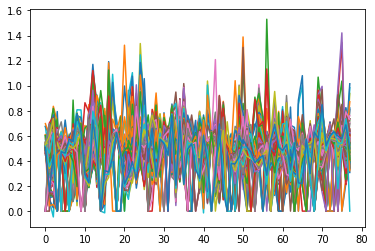

Epoch [4/5000] (LR: 0.0005):
Train loss: 1.0762 || physical loss: 0.0762
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0801 || physical loss: 0.0801
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000


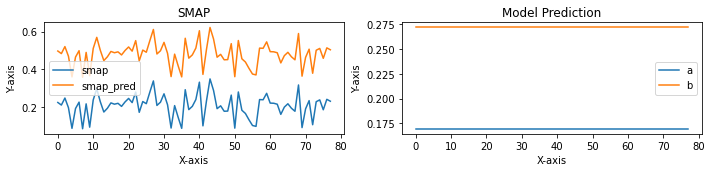

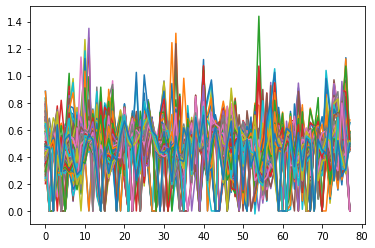

Epoch [5/5000] (LR: 0.0005):
Train loss: 1.0781 || physical loss: 0.0781
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0739 || physical loss: 0.0739
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000


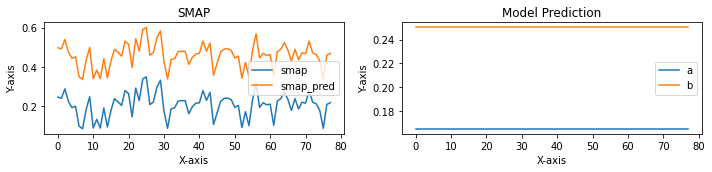

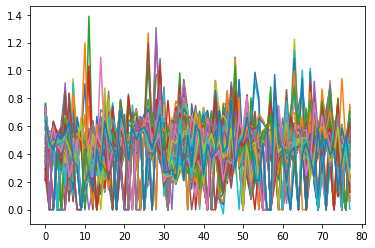

Epoch [6/5000] (LR: 0.0005):
Train loss: 1.0689 || physical loss: 0.0689
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0626 || physical loss: 0.0626
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.063...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


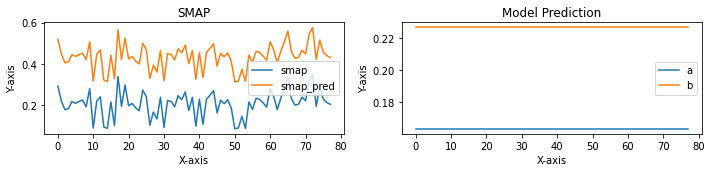

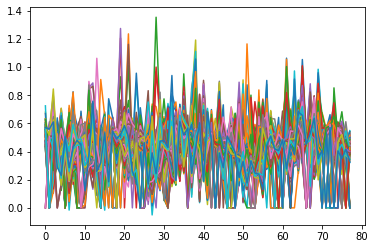

Epoch [7/5000] (LR: 0.0005):
Train loss: 1.0574 || physical loss: 0.0574
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0513 || physical loss: 0.0513
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.051...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


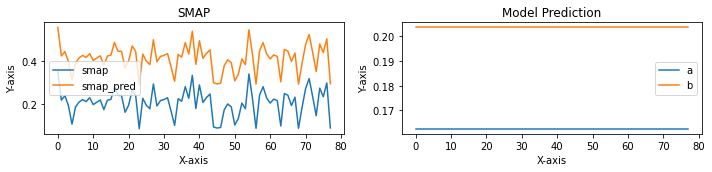

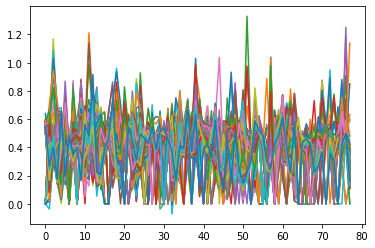

Epoch [8/5000] (LR: 0.0005):
Train loss: 1.0467 || physical loss: 0.0467
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0414 || physical loss: 0.0414
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.041...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


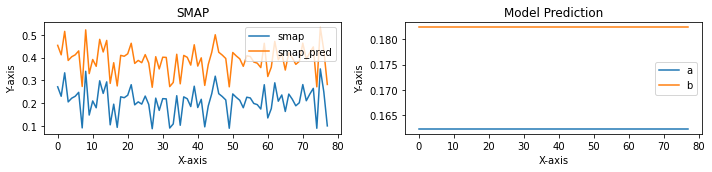

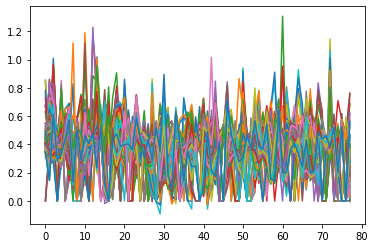

Epoch [9/5000] (LR: 0.0005):
Train loss: 1.0376 || physical loss: 0.0376
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0332 || physical loss: 0.0332
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.033...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


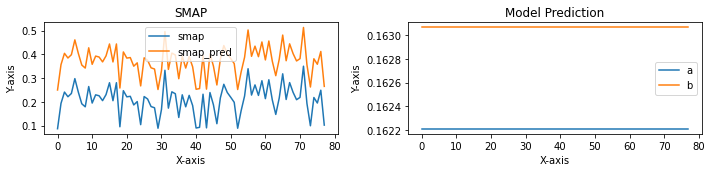

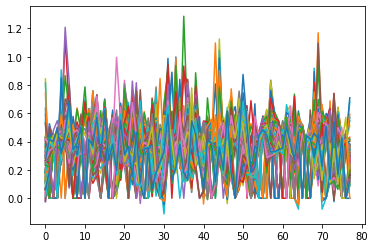

Epoch [10/5000] (LR: 0.0005):
Train loss: 1.0301 || physical loss: 0.0301
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0266 || physical loss: 0.0266
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.027...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


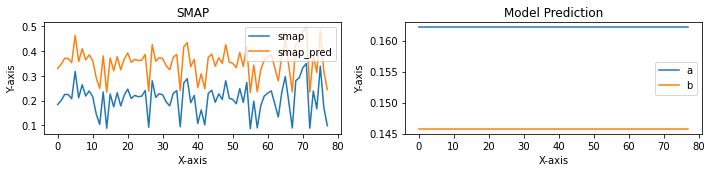

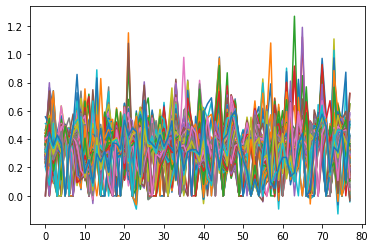

Epoch [11/5000] (LR: 0.0005):
Train loss: 1.0241 || physical loss: 0.0241
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0213 || physical loss: 0.0213
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.021...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


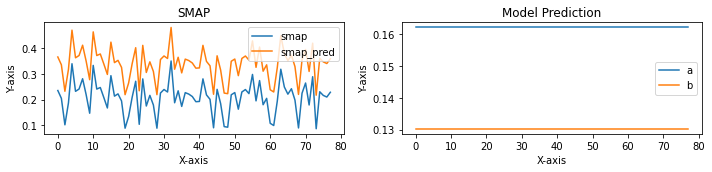

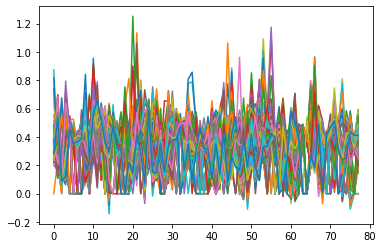

Epoch [12/5000] (LR: 0.0005):
Train loss: 1.0192 || physical loss: 0.0192
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0170 || physical loss: 0.0170
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.017...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


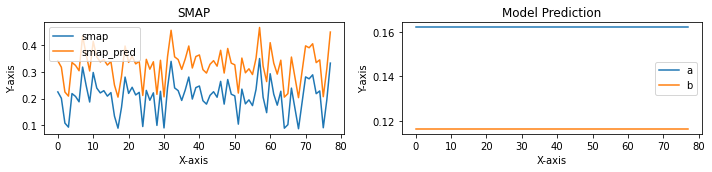

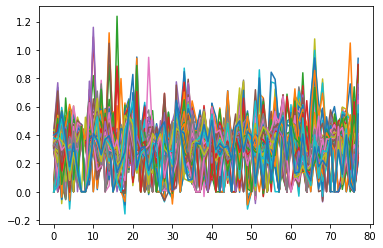

Epoch [13/5000] (LR: 0.0005):
Train loss: 1.0154 || physical loss: 0.0154
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0136 || physical loss: 0.0136
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.014...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


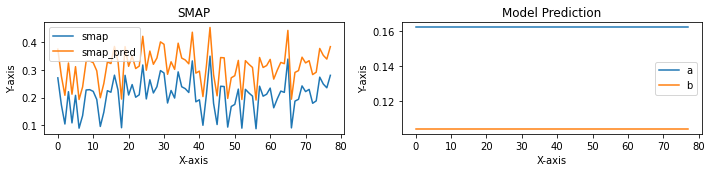

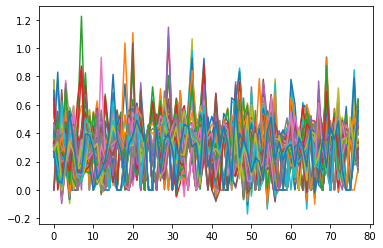

Epoch [14/5000] (LR: 0.0005):
Train loss: 1.0123 || physical loss: 0.0123
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0108 || physical loss: 0.0108
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.011...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


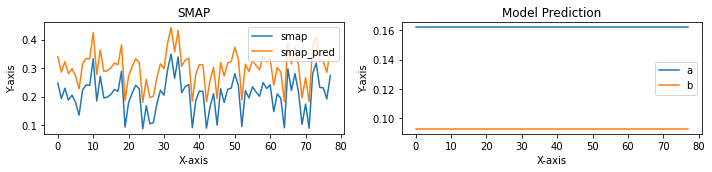

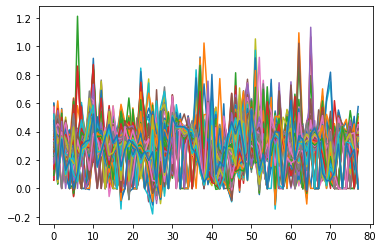

Epoch [15/5000] (LR: 0.0005):
Train loss: 1.0098 || physical loss: 0.0098
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0086 || physical loss: 0.0086
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.009...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


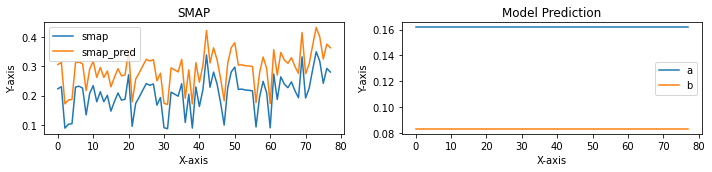

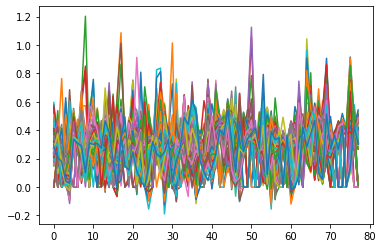

Epoch [16/5000] (LR: 0.0005):
Train loss: 1.0078 || physical loss: 0.0078
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0069 || physical loss: 0.0069
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.007...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


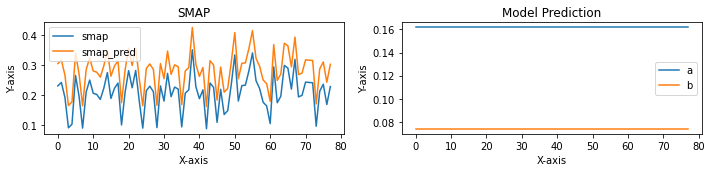

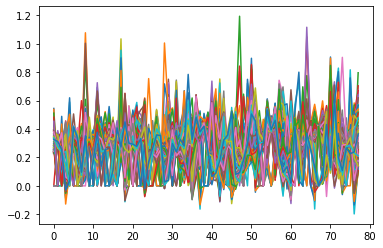

Epoch [17/5000] (LR: 0.0005):
Train loss: 1.0063 || physical loss: 0.0063
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0055 || physical loss: 0.0055
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.006...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


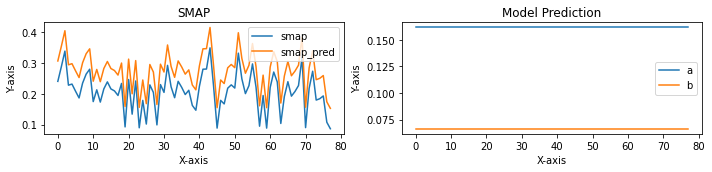

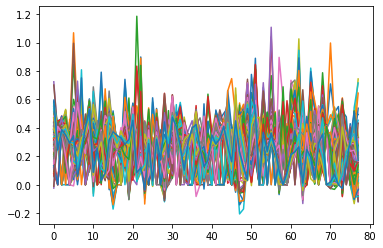

Epoch [18/5000] (LR: 0.0005):
Train loss: 1.0050 || physical loss: 0.0050
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0044 || physical loss: 0.0044
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.004...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


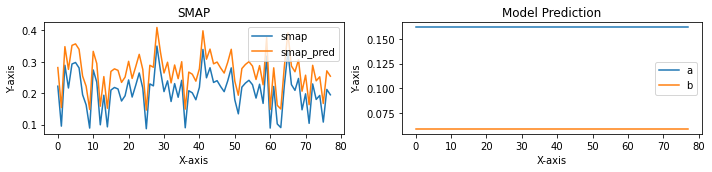

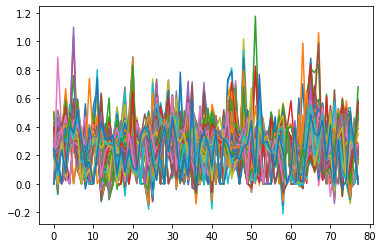

Epoch [19/5000] (LR: 0.0005):
Train loss: 1.0040 || physical loss: 0.0040
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0035 || physical loss: 0.0035
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.004...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


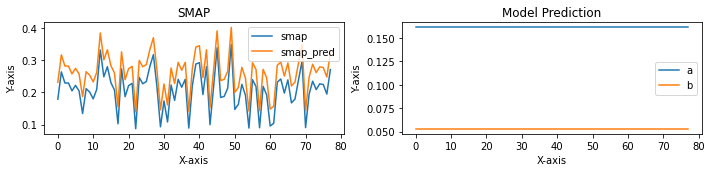

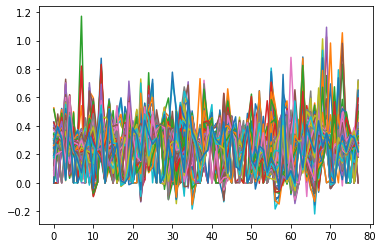

Epoch [20/5000] (LR: 0.0005):
Train loss: 1.0032 || physical loss: 0.0032
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0028 || physical loss: 0.0028
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.003...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


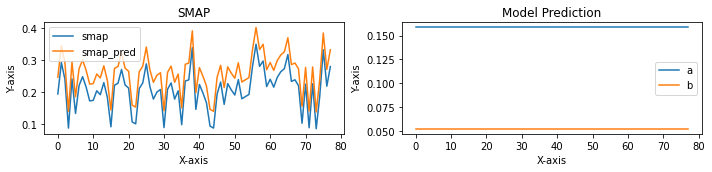

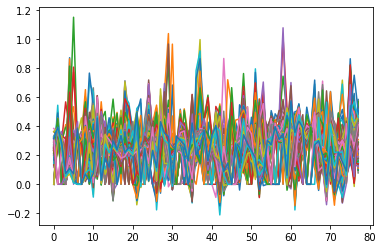

Epoch [21/5000] (LR: 0.00025):
Train loss: 2.5528 || physical loss: 0.0027
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 1.5502 || eds_loss: 1.0000
Valid loss: 1.0027 || physical loss: 0.0027
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.003...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


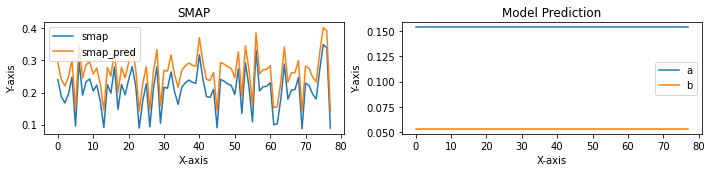

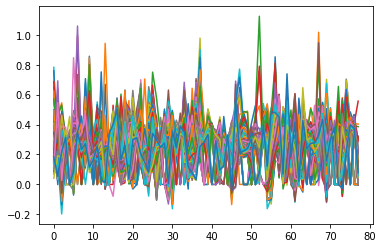

Epoch [22/5000] (LR: 0.00025):
Train loss: 1.0028 || physical loss: 0.0028
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0028 || physical loss: 0.0028
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000


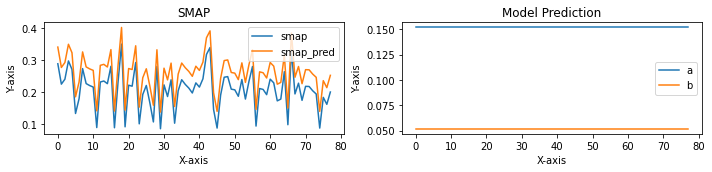

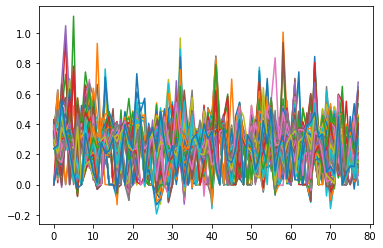

Epoch [23/5000] (LR: 0.00025):
Train loss: 1.0028 || physical loss: 0.0028
Train sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Valid loss: 1.0027 || physical loss: 0.0027
Valid sd_nonzero_loss: 0.0000 || sm_nonzero_loss: 0.0000 || eds_loss: 1.0000
Saving model with loss 1.003...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


In [ ]:
# 创建模型保存目录
if os.path.exists(config['model_save_dir'])==False:
    os.makedirs(config['model_save_dir'], exist_ok=True)
    
if config['is_train']==True:
    print(dataset.get_input_shape(0))
    model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
#     model = model.double()
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [ ]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_smap_loss
    model.eval() 
    loss_record = []
    physical_loss_record = []
    sd_nonzero_loss_record = []
    sm_nonzero_loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sd_nonzero_loss, sm_nonzero_loss = criterion(pred,
                                                                        data_pkg['label_data'],
                                                                        'Validing',
                                                                        config['sd_lambda'],
                                                                        config['sd_threshold'],
                                                                        config['sm_lambda'],
                                                                        config['sm_threshold'])
            loss = physical_loss + sd_nonzero_loss + sm_nonzero_loss
            
            physical_loss_record.append(physical_loss.item())
            sd_nonzero_loss_record.append(sd_nonzero_loss.item())
            sm_nonzero_loss_record.append(sm_nonzero_loss.item())
            loss_record.append(loss.item())

        mean_test_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_test_sd_nonzero_loss = sum(sd_nonzero_loss_record)/len(sd_nonzero_loss_record)
        mean_test_sm_nonzero_loss = sum(sm_nonzero_loss_record)/len(sm_nonzero_loss_record)
        mean_test_loss = sum(loss_record)/len(loss_record)
        
        print(f'Test loss: {mean_test_loss:.4f} || Valid physical loss: {mean_test_physical_loss:.4f}')
        print(f'Test sd_nonzero_loss: {mean_test_sd_nonzero_loss:.4f} || Test sm_nonzero_loss: {mean_test_sm_nonzero_loss:.4f}')
    return loss_record

## 用smap数据集检验预训练模型

In [ ]:
param_path = os.path.join(config['model_save_dir'],'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 

## 用SMAP数据集检验迁移模型

In [ ]:
transf_model_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_TRANSFER'
param_path = os.path.join(transf_model_root,'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 

## 用SMAP数据集检验站点数据单独训练的模型

In [ ]:
insitu_model_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_FROM_INSITU'
param_path = os.path.join(insitu_model_root,'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 